<a href="https://colab.research.google.com/github/jAndrewtomich/2020-US-Elections/blob/main/2020_presidential_votes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langdetect

In [2]:
import os
import time
import missingno as msno
#import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import nltk, re, string, collections, unicodedata

%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
president_county_candidate_df = pd.read_csv('president_county_candidate.csv')

In [4]:
president_county_candidate_df.loc[(president_county_candidate_df.candidate == ' Write-ins'), 'candidate'] = 'Write-ins'

In [5]:
#aggregate votes by state

state_votes_df = president_county_candidate_df.groupby(['state', 'candidate']).total_votes.sum()
state_votes_df = pd.DataFrame(state_votes_df).reset_index()

In [6]:
interests_df = state_votes_df[(state_votes_df.candidate == 'Joe Biden') | (state_votes_df.candidate == 'Donald Trump') | (state_votes_df.candidate == 'Jo Jorgensen') | 
                              (state_votes_df.candidate == 'Write-ins') | (state_votes_df.candidate == 'Kanye West')]

In [7]:
trump_df = interests_df[interests_df.candidate == 'Donald Trump'].reset_index()
trump_df = trump_df.drop('index', axis=1)
biden_df = interests_df[interests_df.candidate == 'Joe Biden'].reset_index()
biden_df = biden_df.drop('index', axis=1)
jorgensen_df = interests_df[interests_df.candidate == 'Jo Jorgensen'].reset_index()
jorgensen_df = jorgensen_df.drop('index', axis=1)
west_df = interests_df[interests_df.candidate == 'Kanye West'].reset_index()
west_df = west_df.drop('index', axis = 1)
writeins_df = interests_df[interests_df.candidate == 'Write-ins'].reset_index()
writeins_df = writeins_df.drop('index', axis = 1)

In [8]:
def extend_data(df):
  result_df = df
  for s in list(trump_df.state):
    if s not in list(df.state):
      result_df = result_df.append({'state':s, 'candidate':'Write-ins', 'total_votes':0}, ignore_index=True)
  return result_df

In [9]:
west_df = extend_data(west_df)

writeins_df = extend_data(writeins_df)

In [10]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (20, 12)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

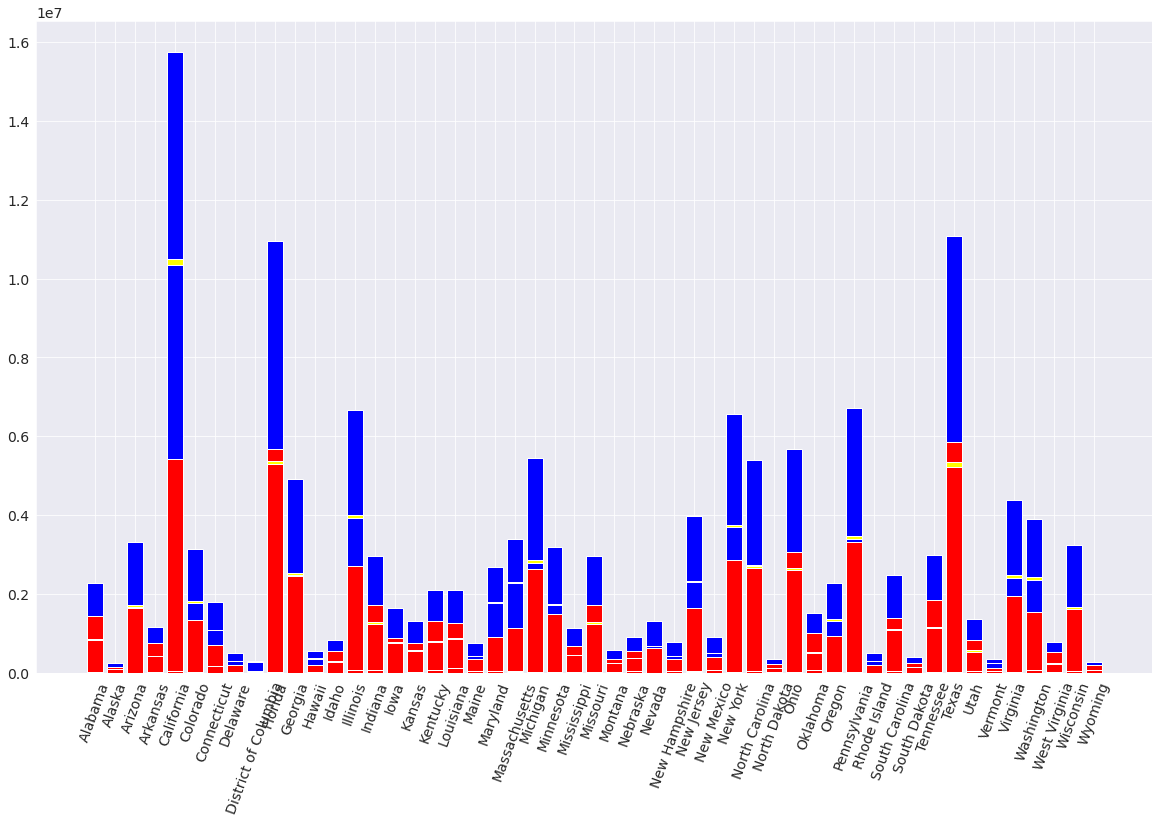

In [11]:
plt.xticks(rotation=70)
plt.bar(trump_df.state, trump_df.total_votes, color='red')
plt.bar(biden_df.state, biden_df.total_votes, color='blue', bottom=trump_df.total_votes)
plt.bar(jorgensen_df.state, jorgensen_df.total_votes, color='yellow', bottom=biden_df.total_votes)
plt.bar(writeins_df.state, writeins_df.total_votes, color='green', bottom=jorgensen_df.total_votes);

# The following is largely lifted directly from the excellent notebook at https://www.kaggle.com/manchunhui/us-presidential-election-sentiment-analysis
# I am changing and adding things for learning purposes.

In [12]:
# Reading both the csv files
tweets_biden_df = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump_df = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

In [13]:
tweets_biden_df['country'].replace({'United States of America':'United States'}, inplace=True)
tweets_biden_df['country'].replace({'United States of America':'United States'}, inplace=True)

In [14]:
# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden_df['user_join_date']=pd.to_datetime(tweets_biden_df['user_join_date'])
tweets_trump_df['user_join_date']=pd.to_datetime(tweets_trump_df['user_join_date'])
tweets_biden_df['collected_at']=pd.to_datetime(tweets_biden_df['collected_at'])
tweets_trump_df['collected_at']=pd.to_datetime(tweets_trump_df['collected_at'])
tweets_biden_df['created_at']=pd.to_datetime(tweets_biden_df['created_at'])
tweets_trump_df['created_at']=pd.to_datetime(tweets_trump_df['created_at'])

# create additional date time columns
tweets_biden_df['created_at_r']=tweets_biden_df['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump_df['created_at_r']=tweets_trump_df['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden_df['created_at_r2']=tweets_biden_df['created_at'].dt.strftime('%m-%d')
tweets_trump_df['created_at_r2']=tweets_trump_df['created_at'].dt.strftime('%m-%d')

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden_df['collected_at'] - tweets_biden_df['created_at'])
t_tdiff=(tweets_trump_df['collected_at'] - tweets_trump_df['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden_df['likes_norm'] = normalise(tweets_biden_df['likes'],b_tdiff)
tweets_biden_df['retweet_norm'] = normalise(tweets_biden_df['retweet_count'],b_tdiff)
tweets_trump_df['likes_norm'] = normalise(tweets_trump_df['likes'],t_tdiff)
tweets_trump_df['retweet_norm'] = normalise(tweets_trump_df['retweet_count'],t_tdiff)

In [15]:
# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [16]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden_df.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump_df.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

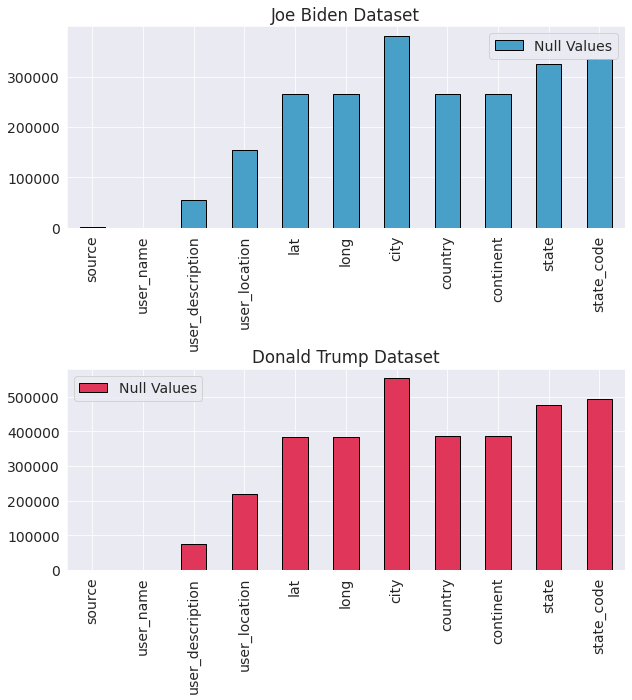

In [17]:
# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(10,10), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()